In [1]:

import os
import re
import yaml
import numpy as np
import pandas as pd
import logging

from scipy import stats, signal
from pathlib import Path
from src.lib.class_load import LoadFiles
from src.data.save_models import SAVE_DIR
from src.lib.utils import select_best_model
from src.lib.factory_data import SQLDataSourceFactory, get_data, create_table, set_data
from src.lib.factory_models import ModelContext
from src.lib.factory_prepare_data import (
    DataCleaner,
    DataModel,
    MeanImputation,
    OutliersToIQRMean,
    PrepareDtypeColumns,
    base_dtypes
)
from src.models.DP_model import Modelos
from src.features.features_redis import HandleRedis
from src.features.features_postgres import HandleDBpsql
from src.models.args_data_model import Parameters
from src.data.logs import LOGS_DIR

path_folder = os.path.dirname('/home/bdebian/Documents/Projects/app_prediction/src')
folder_model = Path(path_folder).joinpath("scr/data/save_models")

handler_load = LoadFiles()
handler_redis = HandleRedis()
data_source = HandleDBpsql()
ruta_actual = os.path.dirname('/home/bdebian/Documents/Projects/app_prediction/src')

# =================================================================
#             Configuracion Logger
# =================================================================
# Configura un logger personalizado en lugar de usar el logger raíz
logfile = ruta_actual + "/src/data/config/logging.conf"
logging.config.fileConfig(os.path.join(LOGS_DIR, logfile))
logger = logging.getLogger("predict")
logger.debug("Inciando secuencia de entrenamiento")

# =================================================================
#             Cargar los parametros
# =================================================================
CONFIG_FILE = ruta_actual + "/src/data/config/config.yaml"
with open(CONFIG_FILE, "r", encoding="utf-8") as file:
    parameters = yaml.safe_load(file)

logger.debug("Archivo de configuraciones cargado")
parametros = Parameters(**parameters)

schema = schema = parametros.connection_data_source['postgresql']['options'].split(',')[
    1]

# =================================================================
#             Cargar datos de la fuente de datos
# =================================================================
# Interacion para hacer un cache de los datos en redis
try:
    logger.debug("verficando si existe data cache")
    data = handler_redis.get_cache_data(
        hash_name=parametros.query_template["table"],
        config=parametros.connection_data_source,
    )
    # Condicional para actualizar datos en caso de existan datos en redis
    if data is not None:
        logger.debug("Existe data en cache")

        # Secuencia de codigo para perdir nuevos datos a la base de datos
        date_col_query = parameters["query_template"]["columns"]["0"]
        LAST_DAY = str(data.iloc[-1][0])
        parameters["query_template"]["where"] = f" \"{date_col_query}\" > '{LAST_DAY}'"
        parameters["query_template"]["order"] = "".join(
            ['"' + columna + '"' for columna in [date_col_query]]
        )

        logger.debug("Realizando peticion a la fuente de datos")

        # Extraccion de la nueva data para actualizar
        new = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Actualizando cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=new,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )
        logger.debug("Actualizacion completa de datos en redis")

    # Verificar que existieran datos en cache
    if data is None:
        logger.debug("No existe cache de datos")

        data = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Insertando datos de cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=None,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )

except ValueError as error:
    logger.debug("[ERROR] No se puede hacer un cache de la fuente de datos")
    logger.debug(error)
    exit()
# =================================================================
#             Limpieza de datos
# =================================================================
new_types = []

for dtypo in parameters["type_data"].values():

    new_types.append(base_dtypes[dtypo])

# metodo para transformar los tipo de datos
strategy = {int: np.mean, float: np.mean, object: stats.mode}

# Estrategias para imputar los datos faltantes de NA
replace = {
    int: lambda x: int(float(x.replace(",", ""))),
    float: lambda x: float(x.replace(",", "")),
    object: lambda x: x.strip(),
}
# =================================================================

update_dtype_columns = PrepareDtypeColumns(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters,
)

# Ejecucion de fabrica para aplicar y ordenar los tipos de datos y los valores
cleaner = DataCleaner()
cleaner.strategy = update_dtype_columns
data_ = cleaner.clean(data)

# Condicion de filtrado para informacion segun los valores
filter_label: str = parameters["filter_data"]["filter_1_feature"]
filter_col: str = parameters["filter_data"]["filter_1_column"]
filter_product = data_.dataframe[filter_col] == filter_label
filter_data = data_.dataframe[filter_product].sort_values(
    by=parameters["filter_data"]["date_column"])

# Seleccion de agrupacion de tiempo
# parameters["filter_data"]["group_frequecy"] = "M"
# parameters["filter_data"]["filter_1_feature"] = filter_label

# # Datos de validacion
# validate_data = filter_data.set_index(time_series_col)["2023-12-01":].reset_index()

# # Datos de entrenamiento
# filter_data = filter_data.set_index(time_series_col)[:"2023-11-30"].reset_index()

outliners = OutliersToIQRMean(**parameters)
cleaner.strategy = outliners
outlines_data = cleaner.clean(filter_data)
# validate_outlines = cleaner.clean(validate_data)

# Filtrado de datos para eliminar valores negativos
filter_values = outlines_data["quantity"] <= 0
outlines_data[filter_values] = 0.1

# =================================================================
#             Filtro pasabajos
# =================================================================
fs = 1 / 24 / 3600  # 1 day in Hz (sampling frequency)

nyquist = fs / 0.5  # 2 # 0.5 times the sampling frequency
cutoff = 0.5  # 0.1 fraction of nyquist frequency, here  it is 5 days
# cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype="lowpass")  # low pass filter

dUfilt = signal.filtfilt(b, a, outlines_data["quantity"])
dUfilt = np.array(dUfilt)
dUfilt = dUfilt.transpose()
outlines_data["low_past"] = dUfilt

# =================================================================
#             Preparacion de datos para el modelo
# =================================================================
data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model
data_ready, scaler_data = cleaner.clean(outlines_data)

# Creacion del dataframe para del filtro pasa bajo para los datos
low_pass_data = outlines_data["low_past"]
low_pass_data = low_pass_data.to_frame()
low_pass_data.rename(columns={"low_past": "quantity"}, inplace=True)
data_ready_lp, scaler_data_lp = cleaner.clean(low_pass_data)

/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


2024-04-08 03:23:27,738 - predict - DEBUG - Inciando secuencia de entrenamiento
2024-04-08 03:23:27,738 - predict - DEBUG - Inciando secuencia de entrenamiento
2024-04-08 03:23:27,742 - predict - DEBUG - Archivo de configuraciones cargado
2024-04-08 03:23:27,742 - predict - DEBUG - Archivo de configuraciones cargado
2024-04-08 03:23:27,743 - predict - DEBUG - verficando si existe data cache
2024-04-08 03:23:27,743 - predict - DEBUG - verficando si existe data cache
2024-04-08 03:23:27,882 - predict - DEBUG - Existe data en cache
2024-04-08 03:23:27,882 - predict - DEBUG - Existe data en cache
2024-04-08 03:23:27,883 - predict - DEBUG - Realizando peticion a la fuente de datos
2024-04-08 03:23:27,883 - predict - DEBUG - Realizando peticion a la fuente de datos
2024-04-08 03:23:27,906 - predict - DEBUG - Actualizando cache en redis
2024-04-08 03:23:27,906 - predict - DEBUG - Actualizando cache en redis
2024-04-08 03:23:27,935 - datasource - DEBUG - Recuperando data existente
2024-04-08 0

Limpiar la salida del modelo

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
validation_date = "2023-12-01"

validation_date  = datetime.strptime(validation_date,"%Y-%m-%d")
forward = validation_date+relativedelta(month=1)

data_prediction_cov, data_test_cov = data_ready_lp.split_after(
    pd.Timestamp(validation_date))

data_prediction, data_test = data_ready.split_after(pd.Timestamp(validation_date))

last_date = data_ready.pd_dataframe().tail(1).index.values
last_date_df = np.datetime_as_string(last_date[0]).split('T')[0]
last_date_format = datetime.strptime(last_date_df, "%Y-%m-%d")
# Numero de meses restantes para hacer el ciclo de validaciones
leftover_monts = relativedelta(last_date_format, validation_date).months

In [4]:
# =================================================================
#            Cargar modelo
# =================================================================
# Rutas de los parametros para predicciones
save_dir = Path(SAVE_DIR).joinpath(parameters["filter_data"]["filter_1_feature"])
models_metrics = save_dir.joinpath("train_metrics").with_suffix(".json").as_posix()

MODE_USED = select_best_model(models_metrics)

scaler_name = save_dir.joinpath("scaler").with_suffix(".pkl").as_posix()
scaler_lp_name = save_dir.joinpath("scaler_lp").with_suffix(".pkl").as_posix()
last_pred = save_dir.joinpath("previus").with_suffix(".json").as_posix()
model_train = save_dir.joinpath(f"model_{MODE_USED}").with_suffix(".pt").as_posix()
parameters_model = save_dir.joinpath(f"parametros_{MODE_USED}").with_suffix(".json").as_posix()

modelo = ModelContext(model_name=MODE_USED,
                      data=data_ready,
                      split=83,
                      covarianze=data_ready_lp,
                      ** parameters
                      )

# Cargar escaler
scaler = handler_load.load_scaler(scaler_name)
scaler_lp = handler_load.load_scaler(scaler_lp_name)

# Cargar modelo para hacer las predicciones
IntModel = Modelos[MODE_USED]
trained_parameters = handler_load.json_to_dict(json_file=parameters_model)[0]
model_update_parameters = IntModel(**trained_parameters)
model_trained = model_update_parameters.load(model_train)


Modelo importado NBeatsModel


In [5]:
#Variable que almacena ultimo valor de la serie de tiempo para luego 
#adjuntarle los valores de las predicciones, y poder graficar las predicciones
data_prediction, data_test = data_ready.split_after(
    pd.Timestamp(validation_date))
plot_time_series = data_prediction.tail(1)
for i in range(leftover_monts):
    forward = validation_date+relativedelta(months=i)

    data_prediction_cov, data_test_cov = data_ready_lp.split_after(
        pd.Timestamp(forward))

    data_prediction, data_test = data_ready.split_after(
        pd.Timestamp(forward))
    
    past_pred, future_pred = modelo.validation(model=model_trained,
                                               data=data_prediction,
                                               past_cov=data_prediction_cov)

    plot_time_series = plot_time_series.append(future_pred)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 511.06it/s]


In [6]:
# =================================================================
#            inverser transform past 
# =================================================================
# Invertir predicciones escaler de entrenamietno
pred_scale = scaler.inverse_transform(past_pred)
data_frame_predicciones = pred_scale.pd_dataframe()
column_field = list(data_frame_predicciones.columns)
data_frame_predicciones.reset_index(inplace=True)
data_frame_predicciones[parameters["filter_data"]
                        ["predict_column"]].clip(lower=0, inplace=True)

# =================================================================
#            inverse transform past
# =================================================================
# Invertir predicciones escaler de entrenamietno
pred_scale_future = scaler.inverse_transform(plot_time_series)
dataframe_pred_future = pred_scale_future.pd_dataframe()
column_field = list(dataframe_pred_future.columns)
dataframe_pred_future.reset_index(inplace=True)
dataframe_pred_future[parameters["filter_data"]
                        ["predict_column"]].clip(lower=0, inplace=True)
dataframe_pred_future = dataframe_pred_future[1:]

/tmp/ipykernel_15265/4040692043.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ["predict_column"]].clip(lower=0, inplace=True)
/tmp/ipykernel_15265/4040692043.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [7]:
outlines_data.reset_index(inplace=True)
outlines_data['low_past'] = filter_label
outlines_data.rename({"low_past": filter_col}, axis="columns", inplace=True)

In [8]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

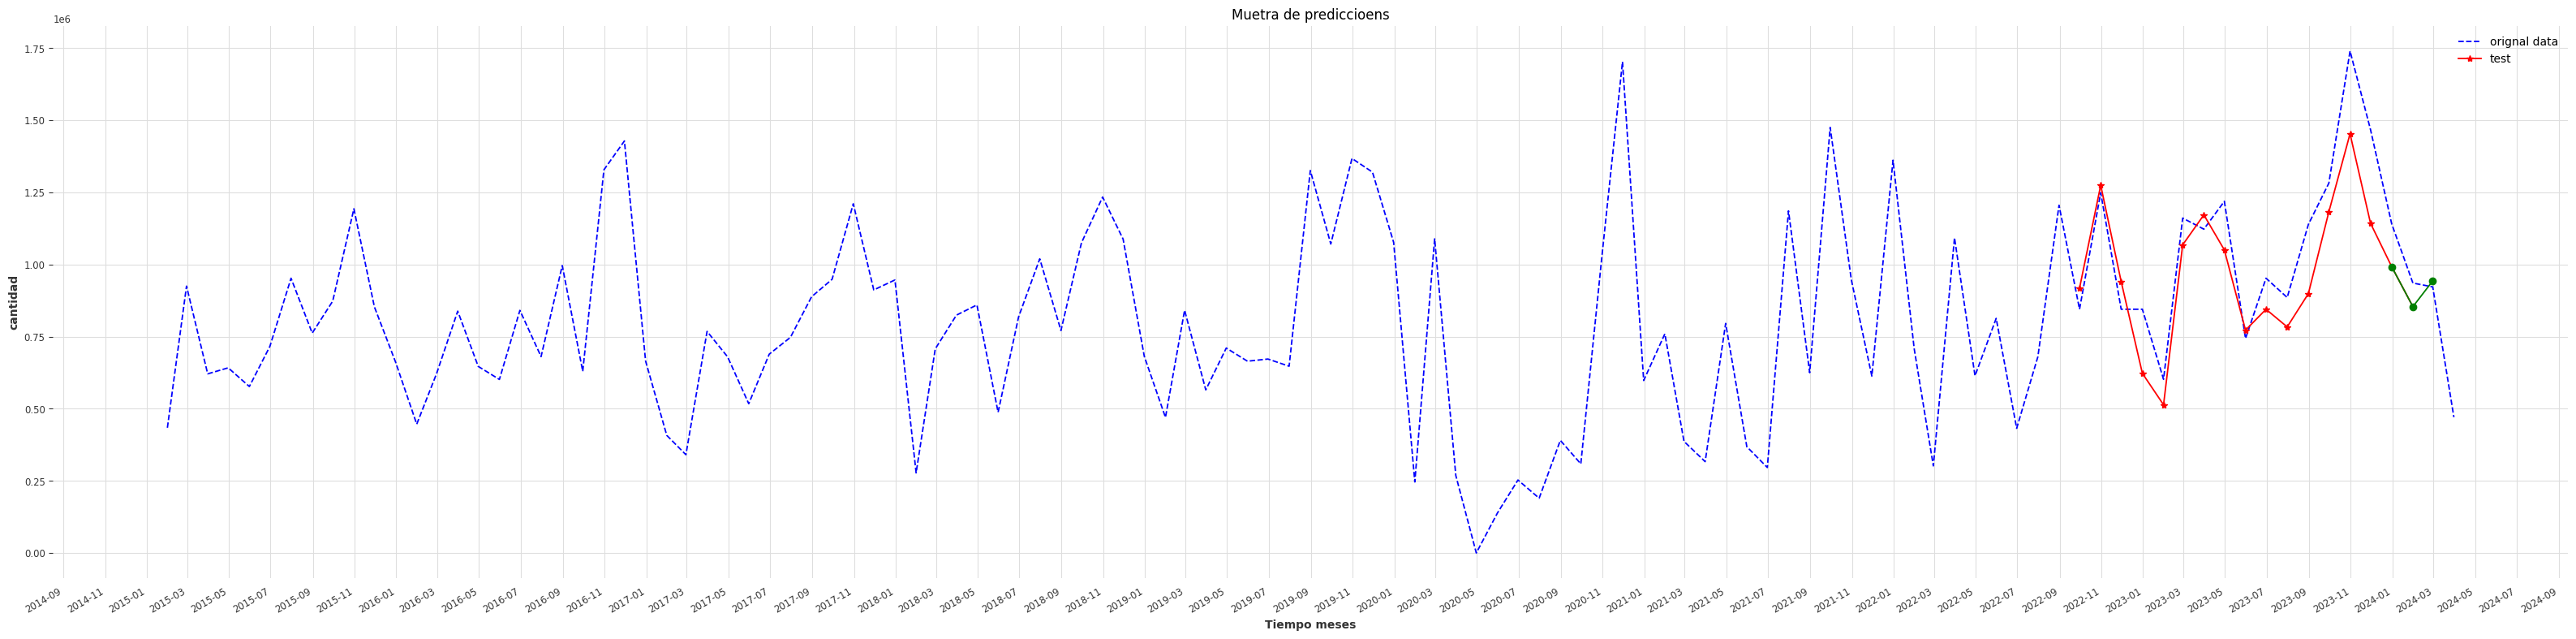

In [9]:
fig, ax = plt.subplots(figsize=(40, 10))

# plt.stem(outlines_data.set_index("created_at").index,
#           outlines_data['quantity'].values,
#           markerfmt='*',basefmt='--'
#           )

# plt.stem(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          markerfmt='*', basefmt='--'
#          )

plt.plot(outlines_data.set_index("created_at").index,
         outlines_data['quantity'].values,
         c = 'b',
         linestyle = '--'
         )

plt.plot(data_frame_predicciones.set_index("time").index,
         data_frame_predicciones['quantity'].values,
         c='r',
         marker = '*'
         )

plt.plot(dataframe_pred_future.set_index("created_at").index,
         dataframe_pred_future['quantity'].values,
         c='g',
         marker = 'o'
         )


plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test', 'validation'])  # , loc='upper right')

fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)
fig.autofmt_xdate()

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test'], loc='upper right')

plt.show()

In [10]:
outlines_data

,created_at,quantity,product
0,2015-01-31,434133.0,90000S
1,2015-02-28,924975.0,90000S
2,2015-03-31,620975.0,90000S
3,2015-04-30,641834.0,90000S
4,2015-05-31,577061.0,90000S
...,...,...,...
106,2023-11-30,1466840.0,90000S
107,2023-12-31,1140400.0,90000S
108,2024-01-31,935600.0,90000S
109,2024-02-29,922400.0,90000S


In [11]:
date_col = parameters["filter_data"]["date_column"]
data_col = parameters["filter_data"]["predict_column"]
data_frame_predicciones['tag'] = 'historical'
data_frame_predicciones['code'] = filter_label
filter_time_col: str = parameters["filter_data"]["date_column"]
data_frame_predicciones.rename(
    {"time": filter_time_col}, axis="columns", inplace=True)

In [12]:
# greater than the start date and smaller than the end date
mask = (outlines_data[date_col] >= data_frame_predicciones[date_col].min()) & (
    outlines_data[date_col] <= data_frame_predicciones[date_col].max())

sub_index_df = outlines_data.loc[mask]

for i, val in data_frame_predicciones.iterrows():
    i = i-1
    error = np.abs(
        data_frame_predicciones[data_col].iloc[i] - sub_index_df[data_col].iloc[i])
    error_p = (np.abs(data_frame_predicciones[data_col].iloc[i] -
               sub_index_df[data_col].iloc[i]) / data_frame_predicciones[data_col].iloc[i]) * 100
    data_frame_predicciones.loc[i+1, 'error'] = round(error, 2)
    data_frame_predicciones.loc[i+1, 'error_per'] = round(error_p, 2)

In [13]:
parameters["query_template_write"]["table"] = "evaluacion_modelos"
parameters["query_template_write"]["columns"]["0"] = date_col
parameters["query_template_write"]["columns"]["1"] = data_col
parameters["query_template_write"]["columns"]["2"] = "tag"
parameters["query_template_write"]["columns"]["3"] = "code"
parameters["query_template_write"]["columns"]["4"] = "error"
parameters["query_template_write"]["columns"]["5"] = "error_per"
parameters["type_data_out"] = {
    date_col: "date", data_col: "float", "tag": "string", "code": "string","error":"float", "error_per":"float"}

# Crear tabla para guardas la informacion
logger.debug(
    "Creando tabla agrupacion de datos reales semanales caso de ser necesario")
create_table(SQLDataSourceFactory(**parameters))

2024-04-08 03:23:29,968 - predict - DEBUG - Creando tabla agrupacion de datos reales semanales caso de ser necesario
2024-04-08 03:23:29,968 - predict - DEBUG - Creando tabla agrupacion de datos reales semanales caso de ser necesario
2024-04-08 03:23:30,287 - datasource - DEBUG - Query enviada
2024-04-08 03:23:30,287 - datasource - DEBUG - Query enviada
2024-04-08 03:23:30,288 - datasource - DEBUG - Finalizacion query
2024-04-08 03:23:30,288 - datasource - DEBUG - Finalizacion query


In [14]:
dataframe_pred_future['tag'] = 'future'
dataframe_pred_future['code'] = filter_label
# greater than the start date and smaller than the end date
mask_future = (outlines_data[date_col] >= dataframe_pred_future[date_col].min()) & (
    outlines_data[date_col] <= dataframe_pred_future[date_col].max())

sub_index_df_future = outlines_data.loc[mask_future]

for i, val in dataframe_pred_future.iterrows():
    i = i-1
    error = np.abs(
        dataframe_pred_future[data_col].iloc[i] - sub_index_df_future[data_col].iloc[i])
    error_p = (np.abs(dataframe_pred_future[data_col].iloc[i] -
               sub_index_df_future[data_col].iloc[i]) / dataframe_pred_future[data_col].iloc[i]) * 100
    dataframe_pred_future.loc[i+1, 'error'] = round(error, 2)
    dataframe_pred_future.loc[i+1, 'error_per'] = round(error_p, 2)

In [15]:
set_data(SQLDataSourceFactory(**parameters), data_frame_predicciones)
set_data(SQLDataSourceFactory(**parameters), dataframe_pred_future)

insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
insertando
2024-04-08 03:23:30,331 - datasource - INFO - Query de insercion de archivo csv finalizada
2024-04-08 03:23:30,331 - datasource - INFO - Query de insercion de archivo csv finalizada
insertando
insertando
insertando
2024-04-08 03:23:30,352 - datasource - INFO - Query de insercion de archivo csv finalizada
2024-04-08 03:23:30,352 - datasource - INFO - Query de insercion de archivo csv finalizada


In [16]:
# # greater than the start date and smaller than the end date
# mask = (outlines_data['created_at'] >= data_frame_predicciones['created_at'].min()) & (
#     outlines_data['created_at'] <= data_frame_predicciones['created_at'].max())

# sub_index_df = outlines_data.loc[mask]

# for i, val in data_frame_predicciones.iterrows():
#     i = i-1
#     # print(data_frame_predicciones['quantity'].iloc[i],
#     #       sub_index_df['quantity'].iloc[i], i)
#     error = np.abs(
#         data_frame_predicciones['quantity'].iloc[i] - sub_index_df['quantity'].iloc[i])
#     error_p = (np.abs(data_frame_predicciones['quantity'].iloc[i] -
#                sub_index_df['quantity'].iloc[i]) / data_frame_predicciones['quantity'].iloc[i]) * 100
#     data_frame_predicciones.loc[i+1, 'Error'] = error
#     data_frame_predicciones.loc[i+1, 'Error %'] = error_p

In [17]:
# # greater than the start date and smaller than the end date
# mask_future = (outlines_data['created_at'] >= dataframe_pred_future['created_at'].min()) & (
#     outlines_data['created_at'] <= dataframe_pred_future['created_at'].max())

# sub_index_df_future = outlines_data.loc[mask_future]

# for i, val in dataframe_pred_future.iterrows():
#     i = i-1
#     print(dataframe_pred_future['quantity'].iloc[i],
#           sub_index_df_future['quantity'].iloc[i], i)
#     error = np.abs(
#         dataframe_pred_future['quantity'].iloc[i] - sub_index_df_future['quantity'].iloc[i])
#     error_p = (np.abs(dataframe_pred_future['quantity'].iloc[i] -
#                sub_index_df_future['quantity'].iloc[i]) / dataframe_pred_future['quantity'].iloc[i]) * 100
#     dataframe_pred_future.loc[i+1, 'Error'] = error
#     dataframe_pred_future.loc[i+1, 'Error %'] = error_p